In [28]:
import json
import numpy as np
from collections import namedtuple
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
with open("603.content-moderation_experiments.json") as inf:
    s3 = json.load(inf)
    
s3.keys()

dict_keys(['_invocations', '_metrics', 'begin_time', 'config', 'end_time', 'result_bucket'])

In [4]:
with open("604.content-moderation-inline_experiments.json") as inf:
    inline = json.load(inf)
    
inline.keys()

dict_keys(['_invocations', '_metrics', 'begin_time', 'config', 'end_time', 'result_bucket'])

Obtain a scatter plot of total processing time vs text size for both types

In [12]:
Data = namedtuple("Data", "processing_time text_size")

In [23]:
# First convert the json dict to an array containing just the two fields
def convert_json_dict_to_pd_arr(data: dict, name: str):
    results = []
    num_cold_skipped = 0
    for exp_name in data["_invocations"][name]:
        result = data["_invocations"][name][exp_name]
        # Ignore cold containers in our results
        if result["output"]["0_is_cold"] or result["output"]["1_is_cold"] or result["output"]["is_cold"]:
            num_cold_skipped += 1
            continue
        results.append(Data(
            result["times"]["benchmark"],
            result["output"]["0_measurement"]["text_size"]
        ))
    print(f"{num_cold_skipped=}")
    return pd.DataFrame(results)

In [24]:
s3_results = convert_json_dict_to_pd_arr(s3, "603.content-moderation-python-3.7")

num_cold_skipped=1


In [25]:
s3_results

,processing_time,text_size
0,65680,961
1,78478,1368
2,70199,794
3,65865,1501
4,61789,802
...,...,...
9994,75765,1028
9995,67406,846
9996,70854,755
9997,77100,2204


In [26]:
inline_results = convert_json_dict_to_pd_arr(inline, "604.content-moderation-inline-python-3.7")

num_cold_skipped=1


In [27]:
inline_results

,processing_time,text_size
0,69661,1437
1,66191,1465
2,46848,784
3,54998,833
4,55949,828
...,...,...
9994,56781,1394
9995,54261,394
9996,46558,1340
9997,50872,1942


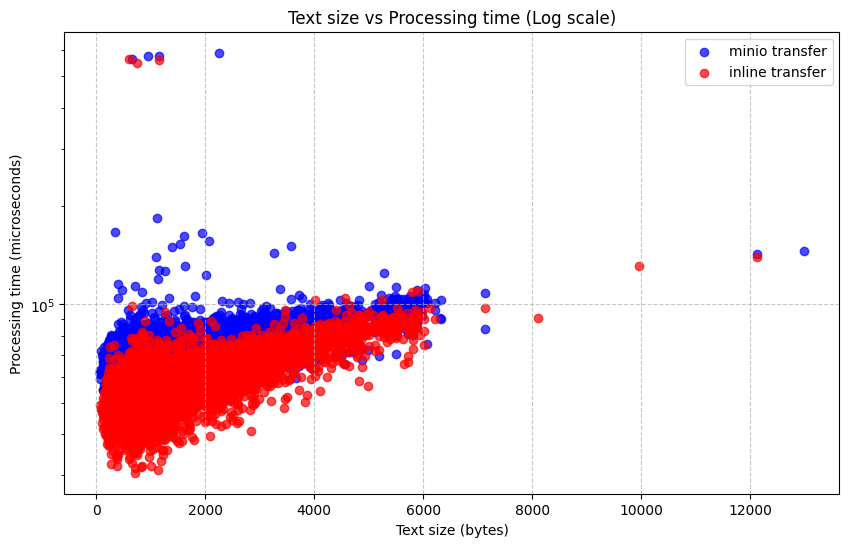

In [34]:
plt.figure(figsize=(10, 6))
plt.scatter(s3_results["text_size"], 
            s3_results["processing_time"],
            color="blue",
            label="minio transfer",
            alpha=0.7)
plt.scatter(inline_results["text_size"], 
            inline_results["processing_time"],
            color="red",
            label="inline transfer",
            alpha=0.7)
plt.yscale("log")

plt.title("Text size vs Processing time (Log scale)")
plt.xlabel("Text size (bytes)")
plt.ylabel("Processing time (microseconds)")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.7)
plt.savefig("Text Size vs Processing Time (Log scale).png")
plt.show()

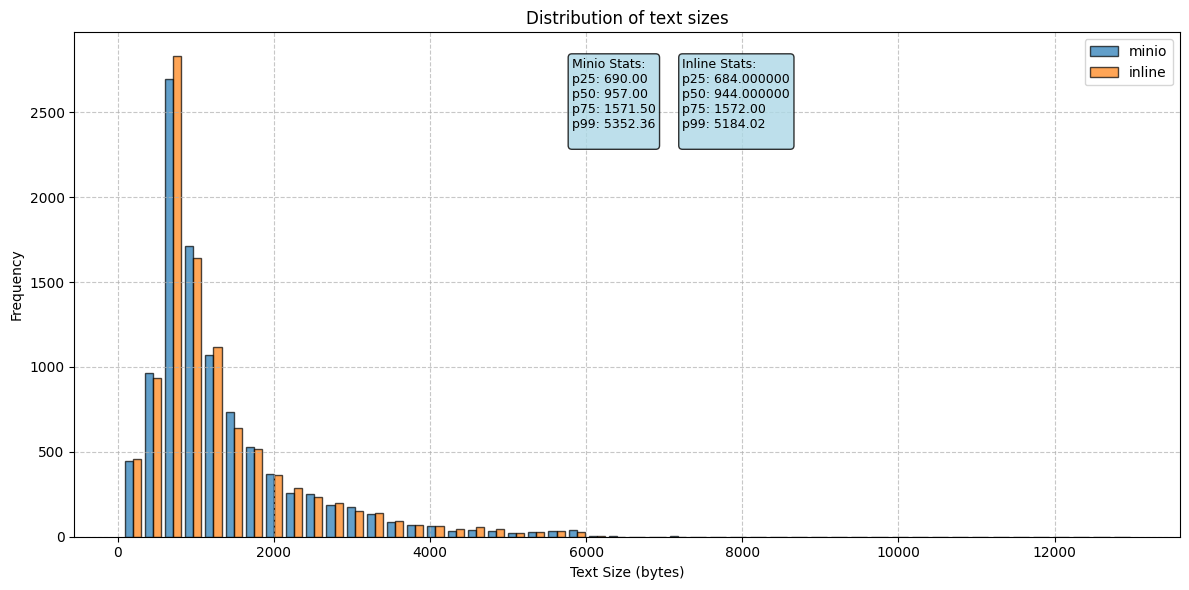

In [44]:
# First calculate distribution
minio_median = np.median(s3_results["text_size"])
minio_25 = np.percentile(s3_results["text_size"], 25)
minio_75 = np.percentile(s3_results["text_size"], 75)
minio_99 = np.percentile(s3_results["text_size"], 99)

minio_stats = f"""Minio Stats:
p25: {minio_25:.2f}
p50: {minio_median:.2f}
p75: {minio_75:.2f}
p99: {minio_99:.2f}
"""

inline_median = np.median(inline_results["text_size"])
inline_25 = np.percentile(inline_results["text_size"], 25)
inline_75 = np.percentile(inline_results["text_size"], 75)
inline_99 = np.percentile(inline_results["text_size"], 99)

inline_stats = f"""Inline Stats:
p25: {inline_25:2f}
p50: {inline_median:2f}
p75: {inline_75:.2f}
p99: {inline_99:.2f}
"""

# Show distribution of text sizes with histogram
plt.figure(figsize=(12, 6))
plt.hist([s3_results["text_size"], inline_results["text_size"]],
         bins=50,
         label=["minio", "inline"],
         edgecolor="black",
         alpha=0.7,
         stacked=False)
plt.title("Distribution of text sizes")
plt.xlabel("Text Size (bytes)")
plt.ylabel("Frequency")

plt.text(0.45, 0.95, minio_stats,
         transform=plt.gca().transAxes,
         fontsize=9,
         verticalalignment="top",
         bbox=dict(boxstyle="round", facecolor="lightblue", alpha=0.8))
plt.text(0.55, 0.95, inline_stats,
         transform=plt.gca().transAxes,
         fontsize=9,
         verticalalignment="top",
         bbox=dict(boxstyle="round", facecolor="lightblue", alpha=0.8))
plt.tight_layout()
plt.legend()
plt.grid(True, linestyle="--", alpha=0.7)
plt.savefig("Distribution of text sizes.png")
plt.show()